# Applied Machine Learning Homework 5
### Po-Chieh Liu (pl2441), Peter Grantcharov (pdg2116)


# Task 3

In [1]:
# base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras import utils

Using TensorFlow backend.


#### Import Data

In [0]:
# import packages for import zip files
import zipfile
import imageio
from skimage import io

In [3]:
# package for load data from google drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# get images
file_dir = '/gdrive/My Drive/Colab Notebooks/Data/IDC_regular_ps50_idx5.zip'

# zipfile
archive = zipfile.ZipFile(file_dir)

# due to memory limit, only extract first 75,000 pictures for this task
images = [f.filename for f in archive.filelist if f.is_dir() == False][:75000]
ic = io.ImageCollection(images, load_func = (lambda x: imageio.imread(archive.read(x))))



#### Drop irregular shape images


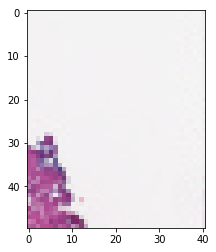

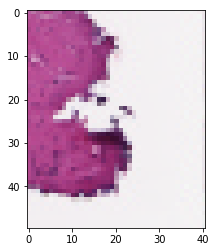

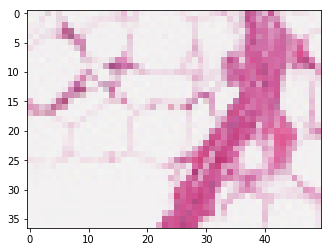

In [5]:
# There are some irregular shape images
# just show the first 3 images
count = 0
for idx, image in enumerate(ic):
    if image.shape != (50, 50, 3):
        count += 1
        plt.figure()
        plt.imshow(image)
    if count == 3:
        break

These irregular shapes are incompatible with our neural networks, so we will simply exclude them from our sample.

In [0]:
# get all images with proper shape
X, y = [], []
for idx, image in enumerate(ic):
    if image.shape == (50, 50, 3):
        X.append(image)
        y.append(images[idx][-5])

# scale features to be between 0 and 1
X = np.array(X) / 255.0
y = utils.to_categorical(np.array(y))

# free memory
del ic, images, archive


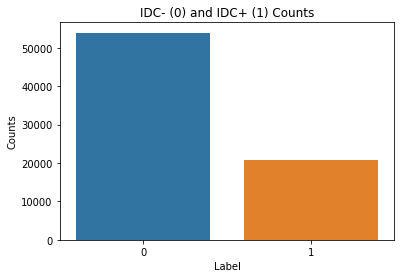

In [7]:
# visualize imbalance
_ = sns.countplot(y[:, 1].astype(int))
_ = plt.xlabel('Label')
_ = plt.ylabel('Counts')
_ = plt.title('IDC- (0) and IDC+ (1) Counts')


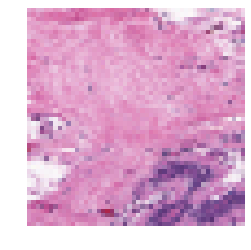

In [8]:
# sample
_ = plt.imshow((X[0] * 255).astype(int))
_ = plt.axis('off')


## Task 3.1
Start with a model without residual connections (using batch normalization is likely to be
helpful and you should try it, whether you use dropout is your choice).

In [0]:
# 80%-20% split data for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size = 0.2)

del X, y

# 80% 20% training data split for training and validating
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, stratify = y_train, test_size = 0.2)


In [10]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 [0, 1],
                                                 y_train[:,1])
class_weights

array([0.69380777, 1.78993795])

In [0]:
# model parameter
batch_size = 50
num_classes = 2
epochs = 10

# input image dimensions
img_rows, img_cols = 50, 50
input_shape = (img_rows, img_cols, 3)


In [0]:
# user defined f1 metric
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


In [13]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

cnn = Sequential()

####### cluster1
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                 input_shape=input_shape))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

###### cluster2
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

###### cluster 3
cnn.add(Conv2D(128, (3, 3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

##### flat for dense
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(32, activation='relu'))
cnn.add(Dense(2, activation='softmax'))

cnn.compile(optimizer='adam', loss="binary_crossentropy", metrics=['acc', f1])

cnn.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 22, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv

In [14]:
hist_cnn = cnn.fit(X_train, 
                   y_train, 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   verbose=1, 
                   validation_data=(X_val,y_val),
                   class_weight = class_weights)


Instructions for updating:
Use tf.cast instead.
Train on 47888 samples, validate on 11973 samples
Epoch 1/10
47888/47888 [==============================] - 17s 346us/step - loss: 0.3855 - acc: 0.8297 - f1: 0.7787 - val_loss: 0.6642 - val_acc: 0.7848 - val_f1: 0.6487
Epoch 2/10
47888/47888 [==============================] - 12s 247us/step - loss: 0.3507 - acc: 0.8463 - f1: 0.8008 - val_loss: 0.8926 - val_acc: 0.7588 - val_f1: 0.5626
Epoch 3/10
47888/47888 [==============================] - 12s 240us/step - loss: 0.3333 - acc: 0.8545 - f1: 0.8117 - val_loss: 0.8816 - val_acc: 0.7835 - val_f1: 0.6447
Epoch 4/10
47888/47888 [==============================] - 12s 241us/step - loss: 0.3211 - acc: 0.8594 - f1: 0.8190 - val_loss: 0.9153 - val_acc: 0.7311 - val_f1: 0.4695
Epoch 5/10
47888/47888 [==============================] - 11s 240us/step - loss: 0.3083 - acc: 0.8673 - f1: 0.8289 - val_loss: 0.5907 - val_acc: 0.8133 - val_f1: 0.7297
Epoch 6/10
47888/47888 [==============================] -

In [15]:
# check test set score
cnn.evaluate(X_test, y_test)


14966/14966 [==============================] - 2s 123us/step


[0.7865344994243064, 0.7386075103408781, 0.5704361179901543]

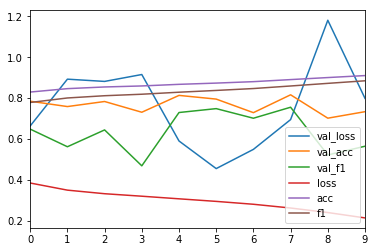

In [16]:
# visulize
_ = pd.DataFrame(hist_cnn.history).plot()

# Summary
In this section, we constructed a relatively simple network comprised of some max pooling, convolutional, and bach normalization layers. We trained the model for 10 epochs, and achieved a test set accuracy score of 0.74. Since the classes are somewhat imbalanced, we also developed an F1 scoring metric, which was 0.57 for the test set. These metrics will act as our baseline from here on out. 


## 3.2 Augment the data using rotations, mirroring and possibly other transformations. How much can you improve your original model by data augmentation?

In [0]:
# apply ImageDataGenerator to augment data
from keras.preprocessing.image import ImageDataGenerator

# apply rotation, shift, zoom and flip
train_datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

train_datagen.fit(X_train)


In [18]:
cnn2 = Sequential()

####### cluster1
cnn2.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                 input_shape=input_shape))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))

###### cluster2
cnn2.add(Conv2D(64, (3, 3), activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))

###### cluster 3
cnn2.add(Conv2D(128, (3, 3), activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))

##### flat for dense
cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dense(64, activation='relu'))
cnn2.add(Dense(32, activation='relu'))
cnn2.add(Dense(2, activation='softmax'))

cnn2.compile(optimizer='adam', loss="binary_crossentropy", metrics=['acc', f1])

cnn2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 22, 22, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 128)         73856     
__________

In [19]:
hist_cnn2 = cnn2.fit_generator(
    train_datagen.flow(X_train,y_train, batch_size=batch_size),
    steps_per_epoch = len(X_train) / batch_size,
    epochs = epochs,
    validation_data = (X_val,y_val),
    verbose=1,
    class_weight = class_weights)


Epoch 1/10
958/957 [==============================] - 40s 42ms/step - loss: 0.3924 - acc: 0.8282 - f1: 0.7778 - val_loss: 0.4372 - val_acc: 0.7862 - val_f1: 0.7521
Epoch 2/10
958/957 [==============================] - 40s 41ms/step - loss: 0.3619 - acc: 0.8415 - f1: 0.7958 - val_loss: 0.5632 - val_acc: 0.8128 - val_f1: 0.7146
Epoch 3/10
958/957 [==============================] - 38s 40ms/step - loss: 0.3523 - acc: 0.8456 - f1: 0.8010 - val_loss: 0.4144 - val_acc: 0.8255 - val_f1: 0.7753
Epoch 4/10
958/957 [==============================] - 39s 41ms/step - loss: 0.3447 - acc: 0.8491 - f1: 0.8055 - val_loss: 1.0191 - val_acc: 0.7818 - val_f1: 0.6317
Epoch 5/10
958/957 [==============================] - 38s 39ms/step - loss: 0.3362 - acc: 0.8541 - f1: 0.8106 - val_loss: 0.5301 - val_acc: 0.7267 - val_f1: 0.6653
Epoch 6/10
958/957 [==============================] - 39s 41ms/step - loss: 0.3296 - acc: 0.8581 - f1: 0.8166 - val_loss: 0.6407 - val_acc: 0.6772 - val_f1: 0.6603
Epoch 7/10
958/9

In [20]:
# check test set score
cnn2.evaluate(X_test, y_test)

14966/14966 [==============================] - 2s 126us/step


[0.7662685723144167, 0.7940665508167287, 0.6709475991847951]

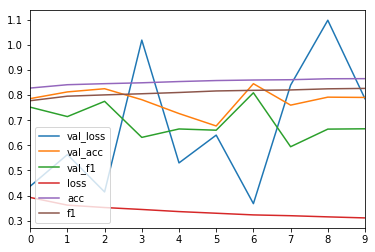

In [21]:
# visualize?
pd.DataFrame(hist_cnn2.history).plot()

# Summary
In this section, we introduced several transformations to our data, in order to hopefully construct a more robust model. Specifically, we used the ImageGenerator class in Keras to perform rotations of up to 90 degrees, as well as several types of flips, zooms, and shifts. 

By training on this transformed data used the same network as in task 3.1, we were able to noticably improve both our test set accuracy and F1 score 0.79 and 0.67, respectively. It should also be noted that the difference between the training and validation set scores were not nearly as large as they were for task 3.1.

# Taks 3.3 
Build a deeper model using residual connections. Show that you can build a deep model that would not be able to learn if you remove the residual connections (i.e. compare a deep model with and without residual connections while the rest of the architecture is constant).

#### Deep net

In [22]:
cnn3 = Sequential()

####### cluster1
cnn3.add(Conv2D(4, kernel_size=(3, 3), activation='relu',
                 input_shape=input_shape, padding = 'same'))
cnn3.add(BatchNormalization())

# create additional 51 layers
for i in range(51):
  cnn3.add(Conv2D(4, (3, 3), activation='relu', padding = 'same'))
  cnn3.add(BatchNormalization())

##### flat for dense
cnn3.add(Flatten())
cnn3.add(Dense(32, activation='relu'))
cnn3.add(Dense(16, activation='relu'))
cnn3.add(Dense(2, activation='softmax'))

cnn3.compile(optimizer='adam', loss="binary_crossentropy", metrics=['acc', f1])

cnn3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 50, 50, 4)         112       
_________________________________________________________________
batch_normalization_7 (Batch (None, 50, 50, 4)         16        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 4)         148       
_________________________________________________________________
batch_normalization_8 (Batch (None, 50, 50, 4)         16        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 4)         148       
_________________________________________________________________
batch_normalization_9 (Batch (None, 50, 50, 4)         16        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 4)         148       
__________

In [23]:
hist_cnn3 = cnn3.fit(X_train, 
                     y_train, 
                     batch_size=batch_size, 
                     epochs=epochs, 
                     verbose=1, 
                     validation_data=(X_val,y_val),
                     class_weight = class_weights)


Train on 47888 samples, validate on 11973 samples
Epoch 1/10
47888/47888 [==============================] - 81s 2ms/step - loss: 0.5894 - acc: 0.7191 - f1: 0.4194 - val_loss: 0.5844 - val_acc: 0.7207 - val_f1: 0.4180
Epoch 2/10
47888/47888 [==============================] - 71s 1ms/step - loss: 0.5740 - acc: 0.7202 - f1: 0.4237 - val_loss: 0.6124 - val_acc: 0.7206 - val_f1: 0.4180
Epoch 3/10
47888/47888 [==============================] - 71s 1ms/step - loss: 0.5686 - acc: 0.7211 - f1: 0.4322 - val_loss: 0.5609 - val_acc: 0.7224 - val_f1: 0.5068
Epoch 4/10
47888/47888 [==============================] - 72s 1ms/step - loss: 0.5560 - acc: 0.7256 - f1: 0.4924 - val_loss: 0.5948 - val_acc: 0.7085 - val_f1: 0.5027
Epoch 5/10
47888/47888 [==============================] - 71s 1ms/step - loss: 0.5712 - acc: 0.7206 - f1: 0.4197 - val_loss: 0.5716 - val_acc: 0.7207 - val_f1: 0.4180
Epoch 6/10
47888/47888 [==============================] - 71s 1ms/step - loss: 0.5235 - acc: 0.7418 - f1: 0.5771 - 

In [24]:
# check test set score
cnn3.evaluate(X_test, y_test)

14966/14966 [==============================] - 4s 290us/step


[0.5279028024103781, 0.7272484297661894, 0.6746583132442427]

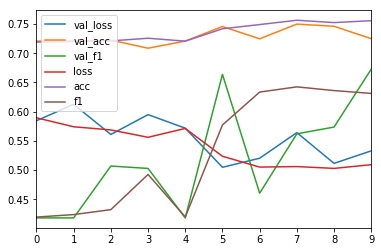

In [25]:
# visualization
_ = pd.DataFrame(hist_cnn3.history).plot()

#### Deep ResNet

In [26]:
from keras.layers import (Dense, Flatten, Conv2D, 
                          BatchNormalization, Input, 
                          add, MaxPooling2D)
from keras import Model

num_classes = 2

inputs = Input(shape=(50,50,3))


lst = [None] * int(5*13)
# total 13 * 4 = 52 conv layers
for i in range(13):
  # 1
  if i == 0:
    lst[0+i*5] = Conv2D(4, (3, 3), activation = 'relu',
                padding = 'same')(inputs)
  else:
    lst[0+i*5] = Conv2D(4, (3, 3), activation = 'relu',
                padding = 'same')(lst[4+(i-1)*5])
  # 2  
  lst[1+i*5] = Conv2D(4, (3, 3), activation = 'relu',
                padding = 'same')(lst[0+i*5])
  # 3
  lst[2+i*5] = Conv2D(4, (3, 3), activation = 'relu',
                padding = 'same')(lst[1+i*5])
  # 4
  lst[3+i*5] = Conv2D(4, (3, 3), activation = 'relu',
                padding = 'same')(lst[2+i*5])
  # skip 
  lst[4+i*5] = add([lst[0+i*5], lst[3+i*5]])
  

flat = Flatten()(lst[-1])
dense1 = Dense(32, activation='relu')(flat)
dense2 = Dense(16, activation='relu')(dense1)
prediction = Dense(2, activation='softmax')(dense2)

model = Model(inputs = inputs, outputs = prediction)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['acc', f1])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 50, 50, 4)    112         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 50, 50, 4)    148         conv2d_59[0][0]                  
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 50, 50, 4)    148         conv2d_60[0][0]                  
__________________________________________________________________________________________________
conv2d_62 

In [27]:
hist_cnn4 = model.fit(X_train, 
                      y_train, 
                      batch_size=batch_size, 
                      epochs=epochs, 
                      verbose=1, 
                      validation_data=(X_val,y_val),
                      class_weight = class_weights
                     )

Train on 47888 samples, validate on 11973 samples
Epoch 1/10
47888/47888 [==============================] - 45s 930us/step - loss: 0.5096 - acc: 0.7569 - f1: 0.5703 - val_loss: 0.4595 - val_acc: 0.7901 - val_f1: 0.7036
Epoch 2/10
47888/47888 [==============================] - 39s 823us/step - loss: 0.4476 - acc: 0.7992 - f1: 0.7260 - val_loss: 0.4276 - val_acc: 0.8085 - val_f1: 0.7337
Epoch 3/10
47888/47888 [==============================] - 40s 826us/step - loss: 0.4209 - acc: 0.8135 - f1: 0.7450 - val_loss: 0.4067 - val_acc: 0.8224 - val_f1: 0.7491
Epoch 4/10
47888/47888 [==============================] - 40s 838us/step - loss: 0.4016 - acc: 0.8226 - f1: 0.7579 - val_loss: 0.3911 - val_acc: 0.8242 - val_f1: 0.7614
Epoch 5/10
47888/47888 [==============================] - 40s 834us/step - loss: 0.3925 - acc: 0.8266 - f1: 0.7653 - val_loss: 0.4058 - val_acc: 0.8167 - val_f1: 0.7325
Epoch 6/10
47888/47888 [==============================] - 39s 825us/step - loss: 0.3845 - acc: 0.8302 - f

In [28]:
model.evaluate(X_test, y_test)

14966/14966 [==============================] - 3s 224us/step


[0.4136357147330733, 0.8196578912599256, 0.7326452597153309]

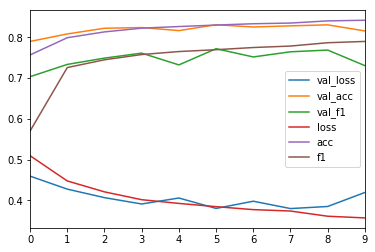

In [29]:
# visualize
_ = pd.DataFrame(hist_cnn4.history).plot()

# Summary
In this final section, we began by building a very deep model with 52 convolutional layers and no residual connections. This ultimately proved to be very ineffective, as the model was too deep to properly learn the data, as evidenced by the training set accuracy and F1 scores of 0.73 and 0.67, respectively. This was almost below our very basic network that we constructed in task 3.1.

For the second part of the task, we added residual connections between every 4 convolutional layers, which turned out to be very effective. The test set performance increased to our best model yet, with accuracy and F1 scores of 0.82 and 0.73, respectively.